In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats import proportion

np.random.seed(0)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("credit_card_default_analysis.csv")
print data.shape
data.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

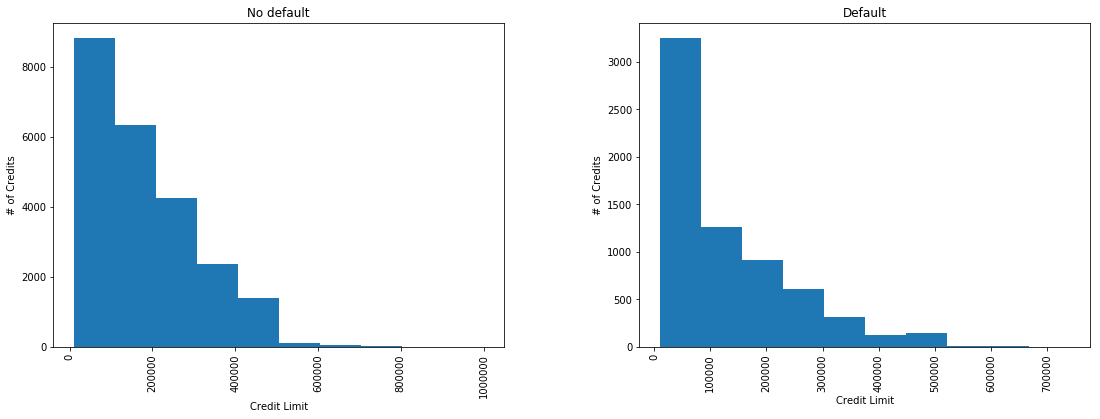

In [3]:
axarr = data.hist("LIMIT_BAL", by="default", figsize=(18, 6))
for i, ax in enumerate(axarr.flatten()):
    ax.set_title("No default" if i == 0 else "Default")
    ax.set_xlabel("Credit Limit")
    ax.set_ylabel("# of Credits")

Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью метода бутсрепа.

In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    return data[indices]

def stat_intervals(stat, alpha):
    return np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

In [5]:
limit_no_default = data[data.default == 0].LIMIT_BAL.values
limit_default = data[data.default == 1].LIMIT_BAL.values

no_default_median_scores = map(np.median, get_bootstrap_samples(limit_no_default, 1000))
default_median_scores = map(np.median, get_bootstrap_samples(limit_default, 1000))

In [6]:
print "95% confidence interval for LIMIT_BAL (no default):", stat_intervals(no_default_median_scores, 0.05)
print "95% confidence interval for LIMIT_BAL (default):", stat_intervals(default_median_scores, 0.05)

95% confidence interval for LIMIT_BAL (no default): [ 150000.  150000.]
95% confidence interval for LIMIT_BAL (default): [ 80000.  90000.]


Можно сделать вывод, что медианы кредитных лимитов не равны. Люди, не отдающие кредиты вовремя, чаще берут кредиты меньше размеров.

Теперь оценим равенство распределений с помощью критерия Манна-Уитни.


H0: медианные значения кредитного лимита равны

H1: H0 неверна

In [7]:
print "p-value:", stats.mannwhitneyu(limit_no_default, limit_default).pvalue

p-value: 6.12774290911e-190


Столь малое значение p-value позволяет нам с уверенностью отвергнуть нулевую гипотезу о равенстве мидиан двух выборок на уровне значимости 0.05.

Данные результаты имеют практическую значимость. У маленьких кредитов больше риск невозврата.

### Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

[<matplotlib.text.Text at 0x116521250>, <matplotlib.text.Text at 0x11652c190>]

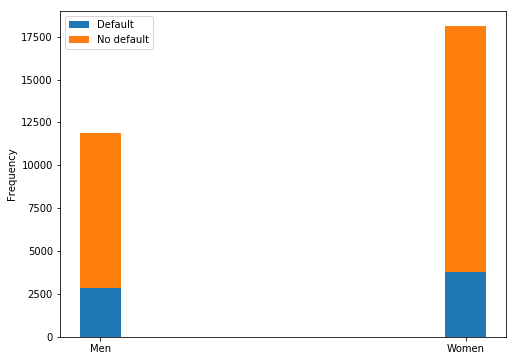

In [8]:
ax = pd.DataFrame({"No default": data[data.default == 0].SEX,
              "Default": data[data.default == 1].SEX,
             }).plot.hist(stacked=True, figsize=(8, 6))

ax.set_xticks([1+0.05, 2-0.05])
ax.set_xticklabels(["Men", "Women"])

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается, используя доверительные интервалы.

In [9]:
no_default_int = proportion.proportion_confint(sum(data[data.default == 0].SEX - 1), data[data.default == 0].shape[0], method='wilson')
default_int = proportion.proportion_confint(sum(data[data.default == 1].SEX - 1), data[data.default == 1].shape[0], method='wilson')

In [10]:
print "Interfval for no default:", no_default_int
print "Interval for default:", default_int

Interfval for no default: (0.60788973403012403, 0.62037268419107494)
Interval for default: (0.55510176302828174, 0.57893758196506595)


Интервалы не пересекаются. Видно, что процент мужчин, не вовращающих кредиты вовремя, слегка больше, чем процент женщин.

Проверим эту же гипотезу, использую z-критерий для разности долей.

H0: гендерный состав людей вернувших и не вернувших кредит не отличается

H1: H0 неверна

In [11]:
def proportions_diff_confint_ind(sample1, sample2, alpha=0.05):
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    
    return (left, right)

def proportions_diff_z_stat_int(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2
    P = float(p1 * n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = "two-sided"):
    if alternative not in ("two-sided", "less", "greater"):
        raise ValueError("Incorrect alternative")
    
    if alternative == "two-sided":
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    if alternative == "less":
        return stats.norm.cdf(z_stat)
    if alternative == "greater":
        return 1 - scipy.stats.norm.cdf(z_stat)


In [12]:
print "Confidence interval:", proportions_diff_confint_ind(data[data.default == 0].SEX - 1, data[data.default == 1].SEX - 1)
print "p-value:", proportions_diff_z_test(proportions_diff_z_stat_int(data[data.default == 0].SEX - 1, data[data.default == 1].SEX - 1))

Confidence interval: (0.033634932749628671, 0.060548077974896725)
p-value: 4.47286652161e-12


Столь малое значение p-value позволяет нам с уверенностью опровергнуть гипотезу о том, что гендерный состав людей, вернувших и не вернувших кредиты, не отличается на уровне значимости 0.05.

### Задание 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

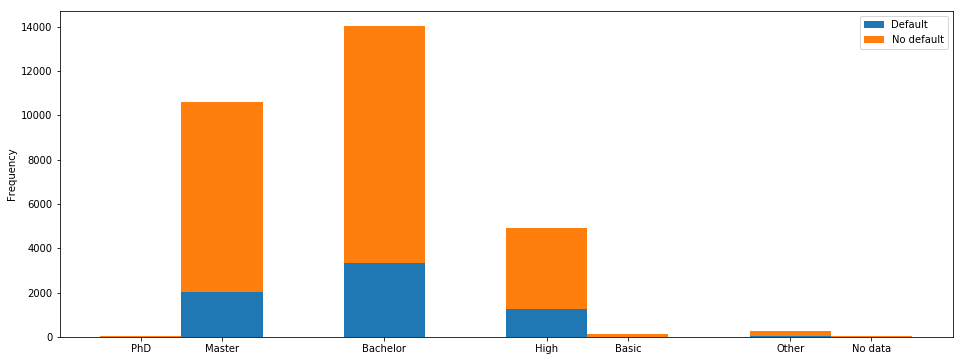

In [13]:
ax = pd.DataFrame({"No default": data[data.default == 0].EDUCATION,
              "Default": data[data.default == 1].EDUCATION,
             }).plot.hist(stacked=True, figsize=(16, 6))

ax.set_xticks([0 + 0.3, 1 - 0.1, 2 + 0.1, 3 + 0.3, 4 - 0.1, 5 + 0.1, 6 - 0.3])
ax.set_xticklabels(["PhD", "Master", "Bachelor", "High", "Basic", "Other", "No data"])

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг, используя критерий Хи-квадрат.

H0: образование не влияет на то, что человек вернет долг

H1: H0 неверна

Составим сводную таблицу, в ячейках которой будет доля людей с конкретным уровнем образования, не допустивших и допустивших дефолт.

In [14]:
observed = pd.DataFrame(
    {"No default": [float(data[(data.default == 0) & (data.EDUCATION == i)].shape[0]) /
                    data[data.EDUCATION == i].shape[0] for i in range(0, 7)],
     "Default": [float(data[(data.default == 1) & (data.EDUCATION == i)].shape[0]) /
                 data[data.EDUCATION == i].shape[0] for i in range(0, 7)]})
observed.index = ["PhD", "Master", "Bachelor", "High", "Basic", "Other", "No data"]
observed

,Default,No default
PhD,0.000000,1.000000
Master,0.192348,0.807652
Bachelor,0.237349,0.762651
High,0.251576,0.748424
Basic,0.056911,0.943089
Other,0.064286,0.935714
No data,0.156863,0.843137


In [15]:
chi2 = stats.chi2_contingency(observed)
print "p-value:", chi2[1]
chi2

p-value: 0.998038881533


(0.48303310222377488,
 0.99803888153345843,
 6,
 array([[ 0.13704734,  0.86295266],
        [ 0.13704734,  0.86295266],
        [ 0.13704734,  0.86295266],
        [ 0.13704734,  0.86295266],
        [ 0.13704734,  0.86295266],
        [ 0.13704734,  0.86295266],
        [ 0.13704734,  0.86295266]]))

Полученное значение p-value не позволяет нам отвергнуть нулевую гипотезу на уровне значимости 0.05.

Составим таблицу сопряженности образования и разности наблюдаемого и ожидаемого количества людей, вернувших долг.

In [16]:
cross = pd.DataFrame(
    {"diff": [data[(data.default == 0) & (data.EDUCATION == i)].shape[0] -
              data[data.EDUCATION == i].shape[0] * chi2[3][i][1]
              for i in range(0, 7)]})
cross.index = ["PhD", "Master", "Bachelor", "High", "Basic", "Other", "No data"]
cross

,diff
PhD,1.918663
Master,-585.353886
Bachelor,-1407.225793
High,-563.138220
Basic,9.856823
Other,20.373256
No data,-1.010586


Данная таблица не является очень информативной, т.к. у нас разное количество людей с разными уровнями образования. Соответственно, каждая строка таблицы имеет свой масштаб. Можно увеличить информативность, если добавить колоку с нормализованным масштабом.

In [17]:
cross["diff fraction"] = [(float(data[(data.default == 0) & (data.EDUCATION == i)].shape[0]) /
                   data[data.EDUCATION == i].shape[0]) -
                   chi2[3][i][1] for i in range(0, 7)]
cross

,diff,diff fraction
PhD,1.918663,0.137047
Master,-585.353886,-0.055300
Bachelor,-1407.225793,-0.100301
High,-563.138220,-0.114529
Basic,9.856823,0.080137
Other,20.373256,0.072762
No data,-1.010586,-0.019815


Из данной таблицы можно сделать вывод, что наличие PhD является наилучшим индикатором того, что человек отдаст долг. А наличие школьного образования - наоборот.

### Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

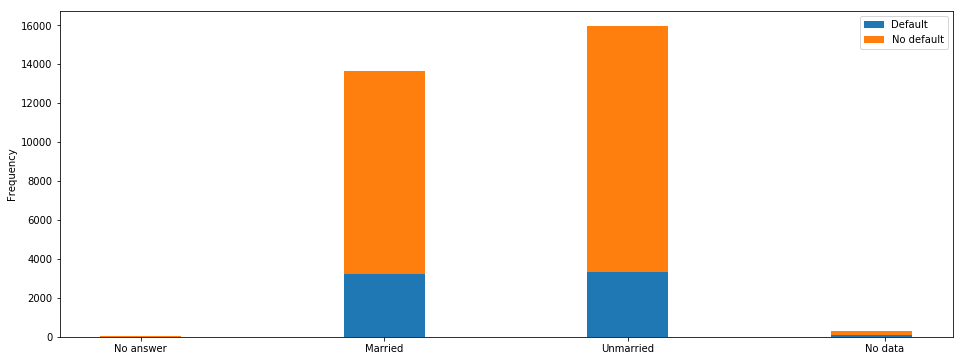

In [18]:
ax = pd.DataFrame({"No default": data[data.default == 0].MARRIAGE,
              "Default": data[data.default == 1].MARRIAGE,
             }).plot.hist(stacked=True, figsize=(16, 6))

ax.set_xticks([0 + 0.15, 1 + 0.05, 2 - 0.05, 3 - 0.1])
ax.set_xticklabels(["No answer", "Married", "Unmarried", "No data"])

Отбросим данные, где семейный статус намеренно скрыт или у нас просто нет данных (эти данные составляют малую часть от всей информации), т.к. нас интересует связь семейного статуса с индикатором дефолта.

[<matplotlib.text.Text at 0x118375350>, <matplotlib.text.Text at 0x117ceb310>]

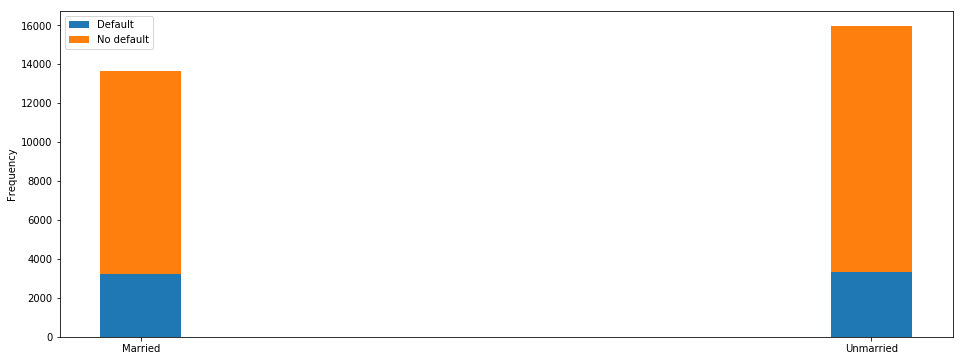

In [19]:
data_m = data[data.MARRIAGE.isin([1, 2])]
ax = pd.DataFrame({"No default": data_m[data_m.default == 0].MARRIAGE,
              "Default": data_m[data_m.default == 1].MARRIAGE,
             }).plot.hist(stacked=True, figsize=(16, 6))

ax.set_xticks([1 + 0.05, 2 - 0.05])
ax.set_xticklabels(["Married", "Unmarried"])

Теперь проверим взаимосвязь семейного статуса и индикатора дефолта, используюя корреляцию Мэттьюса.

In [20]:
t = [[data_m[(data_m.default == 0) & (data_m.MARRIAGE == 2)].shape[0],
      data_m[(data_m.default == 0) & (data_m.MARRIAGE == 1)].shape[0]],
     [data_m[(data_m.default == 1) & (data_m.MARRIAGE == 2)].shape[0],
       data_m[(data_m.default == 1) & (data_m.MARRIAGE == 1)].shape[0]]]
t

[[12623, 10453], [3341, 3206]]

In [21]:
matt_c = (t[0][0] * t[1][1] - t[0][1] * t[1][0]) / np.sqrt((t[0][0] + t[0][1]) *
                                                           (t[0][0] + t[1][0]) *
                                                           (t[0][1] + t[1][1]) *
                                                           (t[1][0] + t[1][1]))
matt_c

0.030555369920445503

Корреляция между семейным статусом и индикатором дефолта практически отсутствует. 

### Задание 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

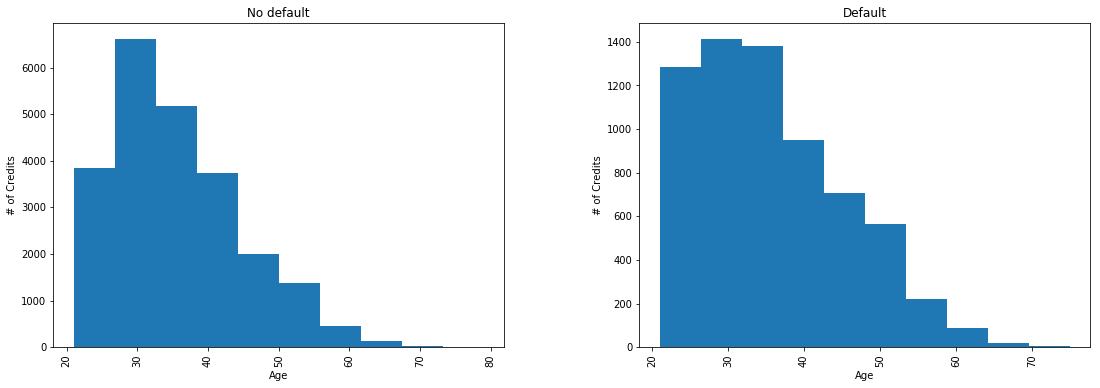

In [22]:
axarr = data.hist("AGE", by="default", figsize=(18, 6))
for i, ax in enumerate(axarr.flatten()):
    ax.set_title("No default" if i == 0 else "Default")
    ax.set_xlabel("Age")
    ax.set_ylabel("# of Credits")

Проверим гипотезу о равенстве медианных значений возраста с помощью метода бутсрепа.

In [23]:
age_no_default = data[data.default == 0].AGE.values
age_default = data[data.default == 1].AGE.values

no_default_age_median_scores = map(np.median, get_bootstrap_samples(age_no_default, 1000))
default_age_median_scores = map(np.median, get_bootstrap_samples(age_default, 1000))

In [24]:
print "95% confidence interval for AGE (no default):", stat_intervals(no_default_age_median_scores, 0.05)
print "95% confidence interval for AGE (default):", stat_intervals(default_age_median_scores, 0.05)

95% confidence interval for AGE (no default): [ 34.  34.]
95% confidence interval for AGE (default): [ 34.  35.]


Интервалы пересекаются. Мы не можем утверждать, что есть зависимость между возрастом и индикатором дефолта.

Теперь оценим равенство распределений с помощью критерия Манна-Уитни.

H0: медианные значения возраста равны

H1: H0 неверна

In [25]:
print "p-value:", stats.mannwhitneyu(age_no_default, age_default).pvalue

p-value: 0.186251771745


Полученное значение p-value не позволяет нам отвергнуть нулевую гипотезу на уровне значимости 0.05.

Данные результат показывает, что возраст не обладает предсказательной силой в задаче предсказания индикатора дефолта.